In [1]:
import os
import datetime
# Get current time
current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Create output folder with the current time as part of the name
folder_name = f"./Output_{current_time}"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 出力
Heatmap_path = folder_name + '/heatmap.png'
Network_path = folder_name + '/network.png'
Plotpoint_path = folder_name + '/plotpoint.png'
GIF_path_100 = folder_name + '/graph_100.gif'
GIF_path_1000 = folder_name + '/graph_1000.gif'

In [2]:
import sqlite3

def SQL_SetUp():
    conn = sqlite3.connect('database.sqlite')
    cursor = conn.cursor()

    # データベースファイルが存在する場合は処理を終了
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    existing_tables = cursor.fetchall()
    if existing_tables:
        print("Database already exists. Exiting setup.")
        conn.close()
        return

    # テーブルを作成
    cursor.execute('''
        CREATE TABLE knowledge (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            angle FLOAT,
            distance FLOAT,
            activation FLOAT DEFAULT 0,
            description TEXT
        )
    ''')

    data = [
        ("直進", 333.44, 1.12, 0),#１番の知識
        ("左寄りの直進", 345.97, 1.03, 0),#２番の知識
        ("右寄りの直進", 0, 1, 0),#１番の知識
        ("右寄りの直進", 14.04, 1.03, 0),#１番の知識
        ("直進", 26.56, 1.12, 0)#１番の知識
    ]


    # データを挿入
    cursor.executemany("INSERT INTO knowledge (description, angle, distance, activation) VALUES (?, ?, ?, ?)", data)


    conn.commit()
    conn.close()

# データベースのセットアップ
SQL_SetUp()


In [5]:
import sqlite3
import pandas as pd

def SQL_GetData():
    conn = sqlite3.connect('database.sqlite')
    cursor = conn.cursor()

    # データを取得してDataFrameに格納
    cursor.execute("SELECT * FROM knowledge")
    rows = cursor.fetchall()
    columns = [description[0] for description in cursor.description]
    df = pd.DataFrame(rows, columns=columns)

    conn.close()

    return df

# データの取得と表示
df = SQL_GetData()
print(df)


   id   angle  distance  activation description
0   1  333.44      1.12         0.0          直進
1   2  345.97      1.03         0.0      左寄りの直進
2   3    0.00      1.00         0.0      右寄りの直進
3   4   14.04      1.03         0.0      右寄りの直進
4   5   26.56      1.12         0.0          直進


In [19]:
# 新しいデータを追加
new_id = len(df) + 1
new_activation = -1.0
new_description = '障害物'
new_angle = float(input('角度を入力してください: '))
new_distance = float(input('距離を入力してください: '))

new_data = pd.DataFrame({
    'id': [new_id],
    'activation': [new_activation],
    'description': [new_description],
    'angle': [new_angle],
    'distance': [new_distance]
})

input_df = pd.concat([df, new_data], ignore_index=True)
# idとdescriptionを結合した文字列を作成
input_df['id_description'] = input_df['id'].astype(str) + '_' + input_df['description']

print(input_df)

   id   angle  distance  activation description id_description
0   1  333.44      1.12         0.0          直進           1_直進
1   2  345.97      1.03         0.0      左寄りの直進       2_左寄りの直進
2   3    0.00      1.00         0.0      右寄りの直進       3_右寄りの直進
3   4   14.04      1.03         0.0      右寄りの直進       4_右寄りの直進
4   5   26.56      1.12         0.0          直進           5_直進
5   6  100.00      2.00        -1.0         障害物          6_障害物


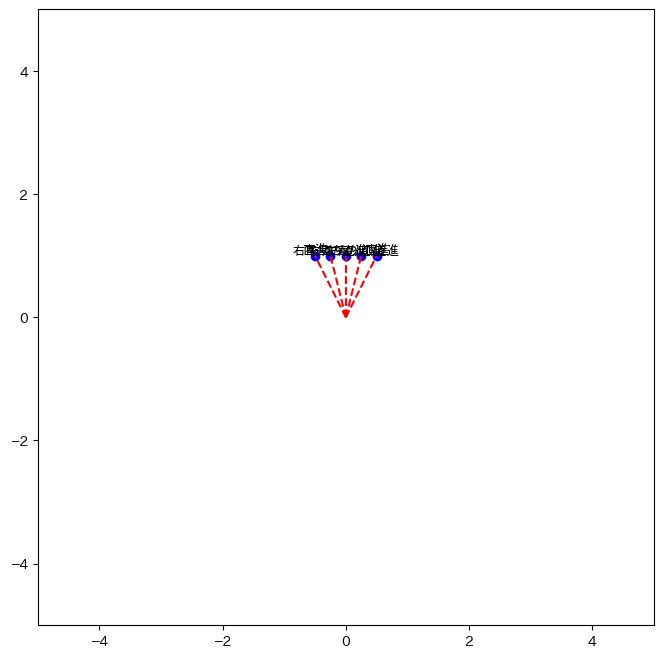

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from matplotlib.font_manager import FontProperties

def plot_points():
    conn = sqlite3.connect('database.sqlite')
    cursor = conn.cursor()

    # データを取得
    cursor.execute("SELECT description, angle, distance FROM knowledge")
    rows = cursor.fetchall()

    conn.close()

    # データを変換
    converted_points = []
    descriptions = []
    for description, angle, distance in rows:
        shifted_angle = angle + 90  # 角度を+90度ずらす
        x = distance * np.cos(np.deg2rad(shifted_angle))
        y = distance * np.sin(np.deg2rad(shifted_angle))
        converted_points.append((x, y))
        descriptions.append(description)

    # 図にプロット
    fig, ax = plt.subplots(figsize=(8, 8))  # グラフのサイズを設定
    ax.set_aspect('equal')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    # MS Gothicフォントを読み込む
    font_prop = FontProperties(fname=r'C:\Windows\Fonts\msgothic.ttc', size=9)

    # ポイントをプロット
    scatter = ax.scatter(*zip(*converted_points), c='b', marker='o')

    # 中心座標を計算
    center_x, center_y = 0, 0

    # 点と中心を線で結ぶ
    for point, description in zip(converted_points, descriptions):
        x, y = point
        ax.plot([center_x, x], [center_y, y], 'r--')
        ax.text(x, y, description, ha='center', va='bottom', fontproperties=font_prop)

    plt.show()

# データのプロット
plot_points()


In [21]:
import pandas as pd
import numpy as np


# クロス表を作成
cross_table = pd.crosstab(input_df['id_description'], input_df['id_description'])
cross_table = cross_table.replace(1, np.nan)

# 新しいデータフレームを表示
print(cross_table)

id_description  1_直進  2_左寄りの直進  3_右寄りの直進  4_右寄りの直進  5_直進  6_障害物
id_description                                                 
1_直進             NaN       0.0       0.0       0.0   0.0    0.0
2_左寄りの直進         0.0       NaN       0.0       0.0   0.0    0.0
3_右寄りの直進         0.0       0.0       NaN       0.0   0.0    0.0
4_右寄りの直進         0.0       0.0       0.0       NaN   0.0    0.0
5_直進             0.0       0.0       0.0       0.0   NaN    0.0
6_障害物            0.0       0.0       0.0       0.0   0.0    NaN


In [22]:
import pandas as pd
import numpy as np

# ベクトルとして角度と距離を使用するため、データを準備
vectors = input_df[['angle', 'distance']]

# ベクトル間のユークリッド距離を計算
distances = np.linalg.norm(vectors.values[:, np.newaxis] - vectors.values, axis=2)

# クロス表に距離を格納
cross_table = pd.DataFrame(distances, index=input_df['id_description'], columns=input_df['id_description'])

# 新しいデータフレームを表示
print(cross_table)


id_description        1_直進    2_左寄りの直進    3_右寄りの直進    4_右寄りの直進        5_直進  \
id_description                                                               
1_直進              0.000000   12.530323  333.440022  319.400013  306.880000   
2_左寄りの直進         12.530323    0.000000  345.970001  331.930000  319.410013   
3_右寄りの直進        333.440022  345.970001    0.000000   14.040032   26.560271   
4_右寄りの直進        319.400013  331.930000   14.040032    0.000000   12.520323   
5_直進            306.880000  319.410013   26.560271   12.520323    0.000000   
6_障害物           233.441659  245.971913  100.005000   85.965473   73.445272   

id_description       6_障害物  
id_description              
1_直進            233.441659  
2_左寄りの直進        245.971913  
3_右寄りの直進        100.005000  
4_右寄りの直進         85.965473  
5_直進             73.445272  
6_障害物             0.000000  


In [23]:
import numpy as np

# ユークリッド距離を評価する指標を計算する関数
def evaluate_distance(distance):
    max_distance = np.nanmax(cross_table.values)  # ユークリッド距離の最大値（NaNを除く）
    scaled_distance = distance / max_distance  # ユークリッド距離を最大値でスケーリング
    evaluation = 1 - scaled_distance  # 1からスケーリングされた距離を引く
    return evaluation

# ユークリッド距離の評価指標を計算し、再度DataFrameに格納
evaluated_values = cross_table.applymap(evaluate_distance)
activation_table = evaluated_values.copy()

# 再度dfを表示
print(activation_table)

id_description      1_直進  2_左寄りの直進  3_右寄りの直進  4_右寄りの直進      5_直進     6_障害物
id_description                                                            
1_直進            1.000000  0.963782  0.036217  0.076799  0.112987  0.325255
2_左寄りの直進        0.963782  1.000000  0.000000  0.040582  0.076770  0.289037
3_右寄りの直進        0.036217  0.000000  1.000000  0.959418  0.923230  0.710943
4_右寄りの直進        0.076799  0.040582  0.959418  1.000000  0.963811  0.751523
5_直進            0.112987  0.076770  0.923230  0.963811  1.000000  0.787712
6_障害物           0.325255  0.289037  0.710943  0.751523  0.787712  1.000000


In [24]:
import numpy as np

# ユークリッド距離を評価する指標を計算する関数
def evaluate_distance(distance):
    max_distance = np.nanmax(cross_table.values)  # ユークリッド距離の最大値（NaNを除く）
    scaled_distance = distance / max_distance  # ユークリッド距離を最大値でスケーリング
    evaluation = 1 - scaled_distance  # 1からスケーリングされた距離を引く
    return evaluation

# ユークリッド距離の評価指標を計算し、再度DataFrameに格納
evaluated_values = cross_table.applymap(evaluate_distance)
activation_table = evaluated_values.copy()

# 評価指標を1/10にスケーリング
activation_table_div10 = activation_table / 10
activation_table_min1 = 1-activation_table


# 再度activation_tableを表示
print(activation_table_div10)


id_description      1_直進  2_左寄りの直進  3_右寄りの直進  4_右寄りの直進      5_直進     6_障害物
id_description                                                            
1_直進            0.100000  0.096378  0.003622  0.007680  0.011299  0.032525
2_左寄りの直進        0.096378  0.100000  0.000000  0.004058  0.007677  0.028904
3_右寄りの直進        0.003622  0.000000  0.100000  0.095942  0.092323  0.071094
4_右寄りの直進        0.007680  0.004058  0.095942  0.100000  0.096381  0.075152
5_直進            0.011299  0.007677  0.092323  0.096381  0.100000  0.078771
6_障害物           0.032525  0.028904  0.071094  0.075152  0.078771  0.100000


In [25]:
input_df2=input_df.copy()
print(input_df)
print(input_df2)

   id   angle  distance  activation description id_description
0   1  333.44      1.12         0.0          直進           1_直進
1   2  345.97      1.03         0.0      左寄りの直進       2_左寄りの直進
2   3    0.00      1.00         0.0      右寄りの直進       3_右寄りの直進
3   4   14.04      1.03         0.0      右寄りの直進       4_右寄りの直進
4   5   26.56      1.12         0.0          直進           5_直進
5   6  100.00      2.00        -1.0         障害物          6_障害物
   id   angle  distance  activation description id_description
0   1  333.44      1.12         0.0          直進           1_直進
1   2  345.97      1.03         0.0      左寄りの直進       2_左寄りの直進
2   3    0.00      1.00         0.0      右寄りの直進       3_右寄りの直進
3   4   14.04      1.03         0.0      右寄りの直進       4_右寄りの直進
4   5   26.56      1.12         0.0          直進           5_直進
5   6  100.00      2.00        -1.0         障害物          6_障害物


In [26]:
import sqlite3
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from PIL import Image  # Import the PIL module
import io
from IPython.display import HTML
from IPython.display import display
from PIL import Image  # Import the PIL module
import glob  # Import the glob module
import japanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import io
import base64
from IPython import display as dd


for i in range(len(activation_table_div10.columns)-1):
    print(activation_table_div10.columns[i], activation_table_div10.columns[-1])
    activity_value_temp = activation_table_div10.loc[activation_table_div10.columns[i], activation_table_div10.columns[-1]]
    input_df2.loc[input_df2['id_description'] == activation_table_div10.columns[i], 'activation'] += activity_value_temp

# 画像を格納するリスト
images = []

while not (input_df2['activation'] > 1).any():
    for i in range(len(activation_table_div10.columns)):
        for j in range(len(activation_table_div10.columns)):
            if i==j:
                continue
            activity_value_temp = activation_table_div10.loc[activation_table_div10.columns[i], activation_table_div10.columns[j]]
            input_df2.loc[input_df2['id_description'] == activation_table_div10.columns[i], 'activation'] += activity_value_temp
            print(input_df2)

            plt.barh(input_df2['id_description'][0:5], input_df2['activation'][0:5])
            
            # グラフのタイトルと軸ラベルの設定
            plt.title('Activation by ID Description')
            plt.xlabel('Activation')
            plt.ylabel('ID Description')
            
            # 画像の保存と追加
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = Image.open(buf)
            images.append(im)
            plt.clf()  # Clear the figure for the next iteration


# GIF画像の保存
images[0].save(GIF_path_100, format='GIF', append_images=images[1:], save_all=True, duration=100, loop=0)
images[0].save(GIF_path_1000, format='GIF', append_images=images[1:], save_all=True, duration=1000, loop=0)

1_直進 6_障害物
2_左寄りの直進 6_障害物
3_右寄りの直進 6_障害物
4_右寄りの直進 6_障害物
5_直進 6_障害物
   id   angle  distance  activation description id_description
0   1  333.44      1.12    0.128904          直進           1_直進
1   2  345.97      1.03    0.028904      左寄りの直進       2_左寄りの直進
2   3    0.00      1.00    0.071094      右寄りの直進       3_右寄りの直進
3   4   14.04      1.03    0.075152      右寄りの直進       4_右寄りの直進
4   5   26.56      1.12    0.078771          直進           5_直進
5   6  100.00      2.00   -1.000000         障害物          6_障害物
   id   angle  distance  activation description id_description
0   1  333.44      1.12    0.132525          直進           1_直進
1   2  345.97      1.03    0.028904      左寄りの直進       2_左寄りの直進
2   3    0.00      1.00    0.071094      右寄りの直進       3_右寄りの直進
3   4   14.04      1.03    0.075152      右寄りの直進       4_右寄りの直進
4   5   26.56      1.12    0.078771          直進           5_直進
5   6  100.00      2.00   -1.000000         障害物          6_障害物
   id   angle  distance  activation description id_

<Figure size 640x480 with 0 Axes>

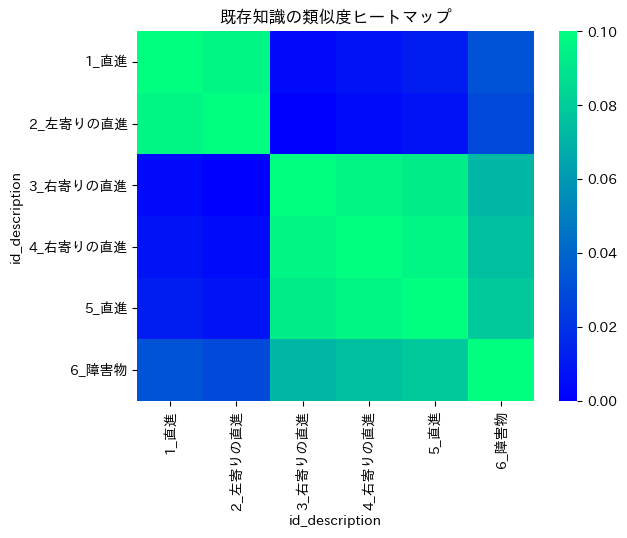

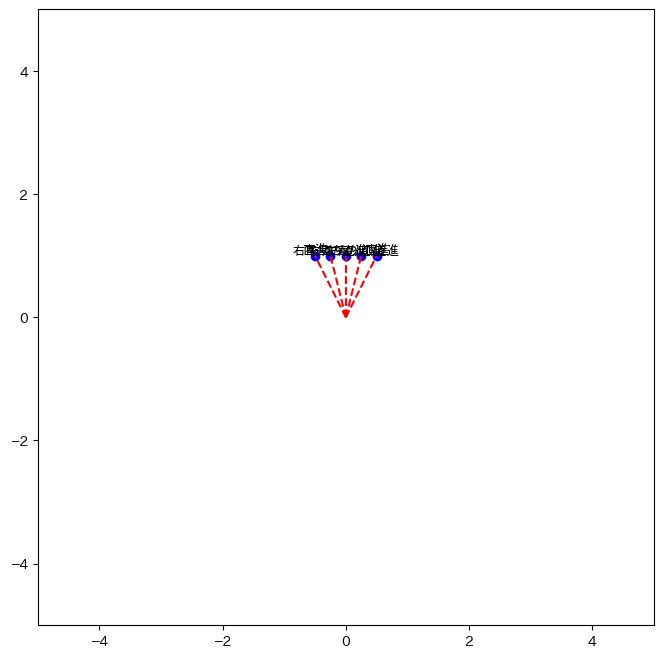

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib


plt.figure()
plt.title("既存知識の類似度ヒートマップ")
sns.heatmap(activation_table_div10,cmap="winter")
plt.savefig(Heatmap_path)
plot_points()


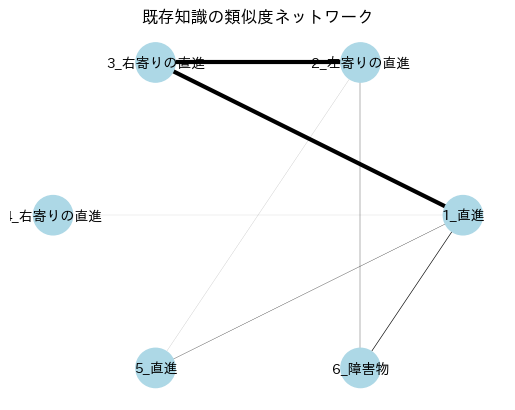

In [28]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

G = nx.from_pandas_adjacency(activation_table_min1, create_using=nx.Graph)

# グラフの描画
pos = nx.circular_layout(G)  # レイアウトアルゴリズムをcircular_layoutに変更
weights = nx.get_edge_attributes(G, 'weight')

# エッジの太さを制限
max_weight = max(weights.values())
edge_widths = [(6 * (1 - weights[edge])) ** 2 for edge in G.edges()]
# エッジの太さの最大値を制限
max_edge_width = 3.0
edge_widths = [min(width, max_edge_width) for width in edge_widths]

# ノードの太さを制限
node_sizes = [50 + 150 * G.degree(node) for node in G.nodes()]
# ノードのサイズの最大値を制限
max_node_size = 1000
node_sizes = [min(size, max_node_size) for size in node_sizes]

# グラフを描画
japanize_matplotlib.japanize()
# 一部のエッジのみ描画
edges_to_draw = [(u, v) for (u, v) in G.edges if weights[(u, v)] > 0.5]
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, width=edge_widths, edge_color='black')
nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', font_color='black', font_size=10)
plt.title("既存知識の類似度ネットワーク")
plt.axis('off')

# グラフを出力
plt.savefig(Network_path)
plt.show()  # グラフを表示するための追加行



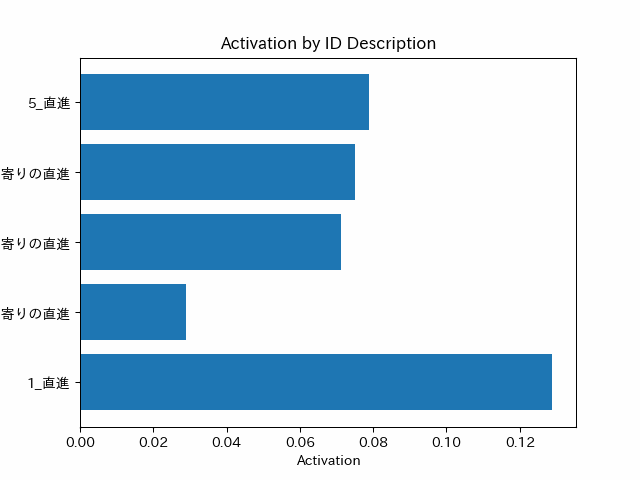

In [29]:
# GIF画像の表示
with open(GIF_path_100, "rb") as f:
    b64 = base64.b64encode(f.read()).decode("ascii")
    
display(dd.HTML(f'<img src="data:image/gif;base64,{b64}" />'))